In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.0 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

In [4]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [11]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

In [13]:
Indices_data = data[['ndvi']]
Indices_data

,ndvi
date,
2000-03-23,0.194392
2000-03-30,0.188009
2000-04-06,0.180129
2000-04-13,0.167050
2000-04-20,0.147221
...,...
2023-01-19,0.179294
2023-01-26,0.198209
2023-02-02,0.210345


In [14]:
end_train = '2020-01-01'
data_train = Indices_data.loc[:end_train, :].copy()
data_test  = Indices_data.loc[end_train:, :].copy()

data_train=data_train.squeeze()
data_test=data_test.squeeze()
data=Indices_data.squeeze()


#### RF

In [15]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(),
                 lags      = 4
             )

In [16]:
# Grid search hyperparameter and lags
# ==============================================================================

lags_grid = [5, 10, 20, 50, 100]
param_distributions = {
    'n_estimators': [20, 30, 50, 100, 200],
    'max_depth': [5, 10, 15,20]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_distributions,
                   lags_grid          = lags_grid,
                   steps              = 1,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = True,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 100.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 0.00019150067183198218



In [17]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(max_depth= 5, n_estimators= 200),
                 lags      = 10
             )
forecaster.fit(data_train)

In [18]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 1,
                                   metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                   initial_train_size    = len(data_train),
                                   fixed_train_size      = True,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = False,
                                   n_jobs                = 'auto',
                                   verbose               = False,
                                   show_progress         = True
                               )

print("Backtest metrics")
display(metric)
print("")
print("Backtest predictions")
predictions_backtest.head(4)

  0%|          | 0/164 [00:00<?, ?it/s]

Backtest metrics


[0.010615564777324704, 0.00018986957721029603, 0.06987570387701642]


Backtest predictions


,pred
2020-01-02,0.265369
2020-01-09,0.257414
2020-01-16,0.261172
2020-01-23,0.260210


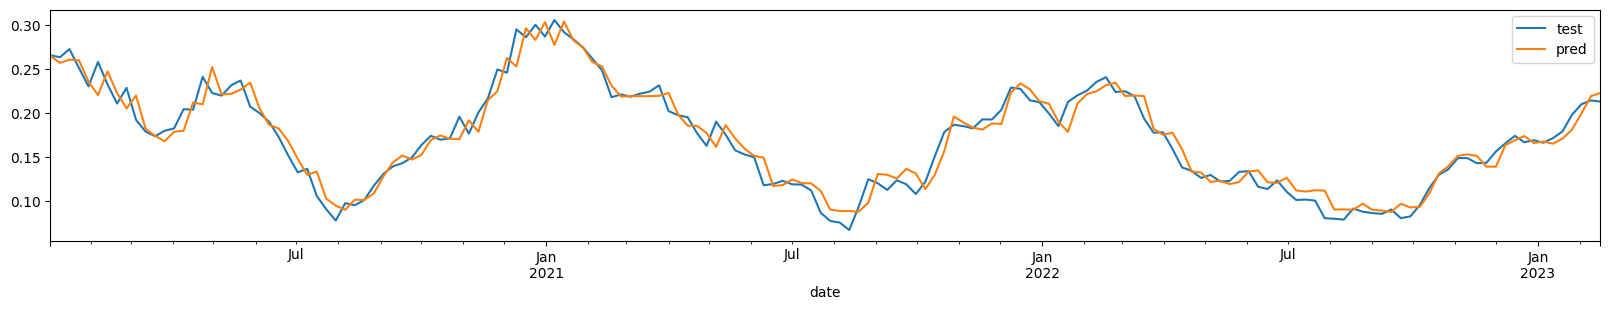

In [19]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [20]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,predictions_backtest)
mse = mean_squared_error(data_test,predictions_backtest)
r2 = r2_score(data_test,predictions_backtest)
rmse = math.sqrt(mean_squared_error(data_test,predictions_backtest))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.010615564777324704
MSE is 0.00018986957721029603
R2 is 0.9426416981956939
RMSE is 0.013779317008121123


#### XGB

In [23]:
!pip install xgboost

In [24]:
from xgboost import XGBRegressor

In [25]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags      = 4
             )

In [26]:
# Grid search hyperparameter and lags
# ==============================================================================

lags_grid = [5, 10, 20, 50, 100]
param_distributions = {
    'n_estimators': [20, 30, 50, 100, 200],
    'max_depth': [5, 10, 15,20]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_distributions,
                   lags_grid          = lags_grid,
                   steps              = 1,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = True,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 100.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 30}
  Backtesting metric: 0.0002196204691469749



In [27]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(max_depth= 5, n_estimators= 30),
                 lags      = 10
             )
forecaster.fit(data_train)

In [28]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 1,
                                   metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                   initial_train_size    = len(data_train),
                                   fixed_train_size      = True,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = False,
                                   n_jobs                = 'auto',
                                   verbose               = False,
                                   show_progress         = True
                               )

print("Backtest metrics")
display(metric)
print("")
print("Backtest predictions")
predictions_backtest.head(4)

  0%|          | 0/164 [00:00<?, ?it/s]

Backtest metrics


[0.011580318010953019, 0.0002196204691469749, 0.074942904060221]


Backtest predictions


,pred
2020-01-02,0.275074
2020-01-09,0.259715
2020-01-16,0.265344
2020-01-23,0.252377


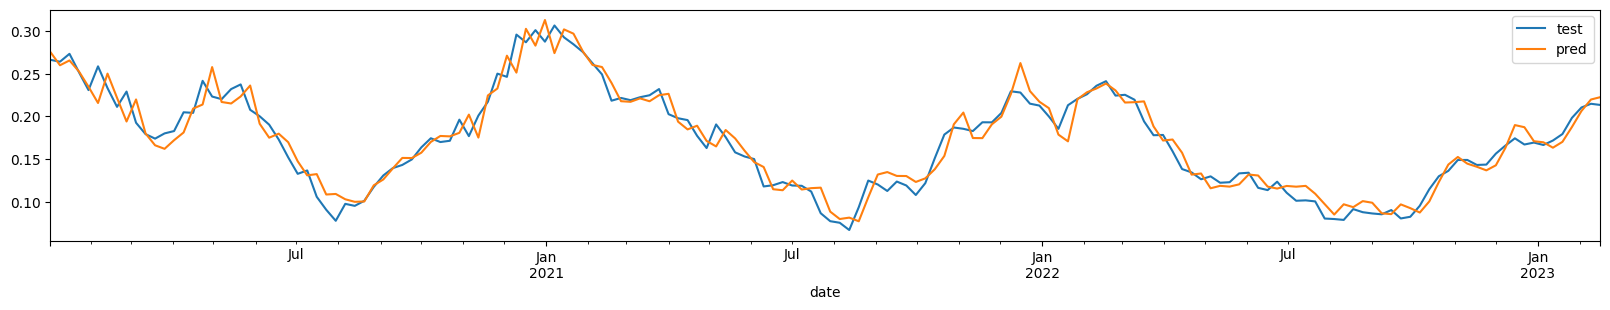

In [29]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [30]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,predictions_backtest)
mse = mean_squared_error(data_test,predictions_backtest)
r2 = r2_score(data_test,predictions_backtest)
rmse = math.sqrt(mean_squared_error(data_test,predictions_backtest))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.011580318010953019
MSE is 0.0002196204691469749
R2 is 0.9336541570438995
RMSE is 0.014819597469127659


In [31]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=60)
predictions.head(3)

2020-01-02    0.275074
2020-01-09    0.274191
2020-01-16    0.273168
Freq: 7D, Name: pred, dtype: float64

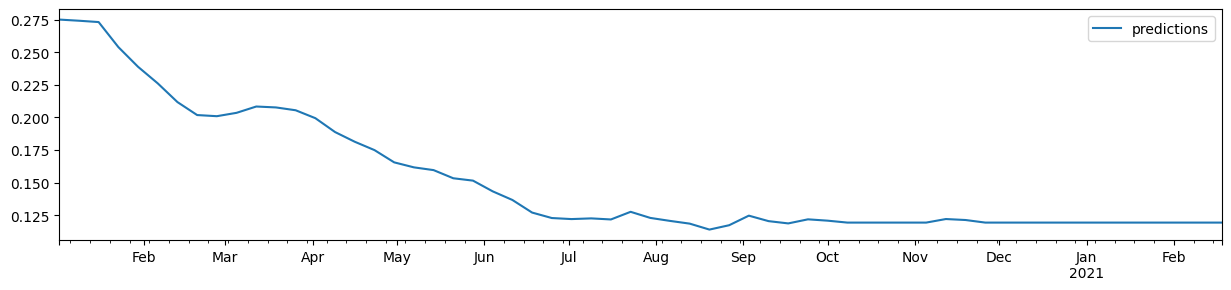

In [32]:
fig, ax = plt.subplots(figsize=(15, 3))
predictions.plot(ax=ax, label='predictions')
ax.legend();

#### LGBM

In [33]:
from lightgbm import LGBMRegressor

In [34]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(),
                 lags      = 4
             )

In [35]:
# Grid search hyperparameter and lags
# ==============================================================================

lags_grid = [5, 10, 20, 50, 100]
param_distributions = {
    'n_estimators': [20, 30, 50, 100, 200],
    'max_depth': [5, 10, 15,20]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_distributions,
                   lags_grid          = lags_grid,
                   steps              = 1,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = True,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 100.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/20 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be ba

In [40]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(max_depth= 5, n_estimators= 100),
                 lags      = 10
             )
forecaster.fit(data_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 10
[LightGBM] [Info] Start training from score 0.183863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [41]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 1,
                                   metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                   initial_train_size    = len(data_train),
                                   fixed_train_size      = True,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = False,
                                   n_jobs                = 'auto',
                                   verbose               = False,
                                   show_progress         = True
                               )

print("Backtest metrics")
display(metric)
print("")
print("Backtest predictions")
predictions_backtest.head(4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 10
[LightGBM] [Info] Start training from score 0.183863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

  0%|          | 0/164 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[0.011350688726287065, 0.00020221257236012735, 0.07303776226405359]


Backtest predictions


,pred
2020-01-02,0.273410
2020-01-09,0.264835
2020-01-16,0.257044
2020-01-23,0.254332


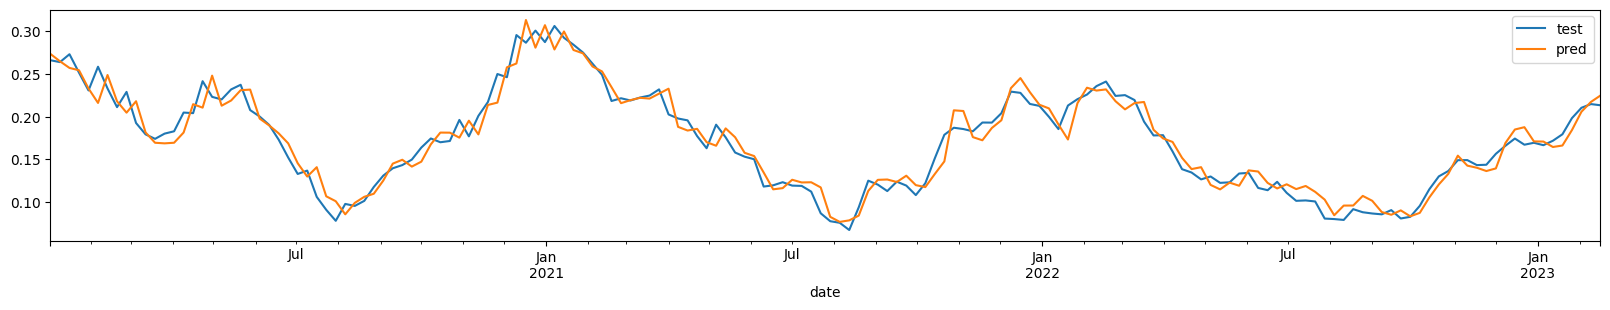

In [42]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [43]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,predictions_backtest)
mse = mean_squared_error(data_test,predictions_backtest)
r2 = r2_score(data_test,predictions_backtest)
rmse = math.sqrt(mean_squared_error(data_test,predictions_backtest))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.011350688726287065
MSE is 0.00020221257236012735
R2 is 0.9389129637066032
RMSE is 0.014220146706701986


#### CB

In [47]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.1 MB/s eta 0:00:00


In [48]:
from catboost import CatBoostRegressor

In [51]:
forecaster = ForecasterAutoreg(
                 regressor = CatBoostRegressor(),
                 lags      = 4
             )

In [ ]:
# Grid search hyperparameter and lags
# ==============================================================================

lags_grid = [5, 10, 20, 50, 100]
param_distributions = {
    'n_estimators': [20, 30, 50, 100, 200],
    'max_depth': [5, 10, 15]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data,
                   param_grid         = param_distributions,
                   lags_grid          = lags_grid,
                   steps              = 1,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = True,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 75.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/15 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
35:	learn: 0.0131777	total: 29.9s	remaining: 2m 16s
36:	learn: 0.0130548	total: 30.6s	remaining: 2m 15s
37:	learn: 0.0129289	total: 31.4s	remaining: 2m 13s
38:	learn: 0.0128216	total: 32.2s	remaining: 2m 12s
39:	learn: 0.0127335	total: 33s	remaining: 2m 11s
40:	learn: 0.0126094	total: 33.8s	remaining: 2m 10s
41:	learn: 0.0125311	total: 34.5s	remaining: 2m 9s
42:	learn: 0.0124432	total: 35.3s	remaining: 2m 9s
43:	learn: 0.0123779	total: 36.1s	remaining: 2m 8s
44:	learn: 0.0122593	total: 36.9s	remaining: 2m 7s
45:	learn: 0.0121888	total: 38s	remaining: 2m 7s
46:	learn: 0.0121032	total: 39.2s	remaining: 2m 7s
47:	learn: 0.0120279	total: 40.4s	remaining: 2m 7s
48:	learn: 0.0119165	total: 41.2s	remaining: 2m 7s
49:	learn: 0.0118127	total: 42s	remaining: 2m 5s
50:	learn: 0.0117467	total: 42.8s	remaining: 2m 5s
51:	learn: 0.0116405	total: 43.6s	remaining: 2m 4s
52:	learn: 0.0115066	total: 44.4s	remaining: 2m 3s
53:	learn: 0.0114464	total: 45.

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor = CatBoostRegressor(max_depth= 5, n_estimators= 100),
                 lags      = 10
             )
forecaster.fit(data_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 10
[LightGBM] [Info] Start training from score 0.183863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 1,
                                   metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                   initial_train_size    = len(data_train),
                                   fixed_train_size      = True,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = False,
                                   n_jobs                = 'auto',
                                   verbose               = False,
                                   show_progress         = True
                               )

print("Backtest metrics")
display(metric)
print("")
print("Backtest predictions")
predictions_backtest.head(4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 10
[LightGBM] [Info] Start training from score 0.183863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

  0%|          | 0/164 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[0.011350688726287065, 0.00020221257236012735, 0.07303776226405359]


Backtest predictions


,pred
2020-01-02,0.273410
2020-01-09,0.264835
2020-01-16,0.257044
2020-01-23,0.254332


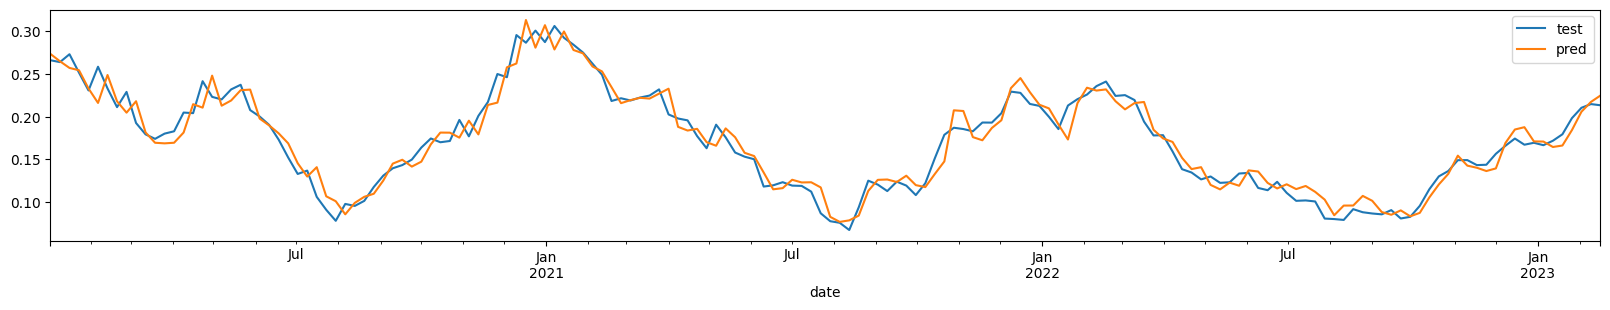

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 3))
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,predictions_backtest)
mse = mean_squared_error(data_test,predictions_backtest)
r2 = r2_score(data_test,predictions_backtest)
rmse = math.sqrt(mean_squared_error(data_test,predictions_backtest))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))
print('RMSE is {}'.format(rmse))

The model performance for testing set:
--------------------------------------

MAE is 0.011350688726287065
MSE is 0.00020221257236012735
R2 is 0.9389129637066032
RMSE is 0.014220146706701986
